<a href="https://colab.research.google.com/github/friedameissner/BA/blob/main/NMF_Dravnieks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/Uni/BA/Dravnieks

/content/drive/My Drive/Uni/BA/Dravnieks


In [ ]:
%cd /content/

/content


In [3]:
import numpy as np
import scipy.io as sio
from scipy.cluster.hierarchy import cophenet, linkage, dendrogram, fcluster
from scipy.stats import entropy
#from scipy.special import kl_div, rel_entr
from sklearn.preprocessing import normalize
from sklearn.decomposition import NMF, PCA
from sklearn.model_selection import train_test_split #, validation_curve, KFold
from sklearn.metrics import explained_variance_score
from sklearn.cluster import KMeans, SpectralCoclustering, SpectralBiclustering
from sklearn.manifold import TSNE
import statistics as stat
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cv2

## NMF

In [4]:
s_opt = 29

In [13]:
def kl_divergence(data, target="W", n_comp=s_opt, n_iter=250, name_mat="W_list"):
    if target == "W":
        W_list = np.empty((n_iter, data.shape[0], n_comp))

    elif target == "H":
        W_list = np.empty((n_iter, n_comp, data.shape[1]))

    else:
        raise Exception("Target must be either \"W\" or \"H\".")

    for i in range(n_iter):
        model = NMF(n_components=n_comp, init='random', solver='cd', beta_loss='frobenius', tol=1e-4,
                    max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same', l1_ratio=0.1,
                    verbose=0, shuffle=False)

        if target == "W":
            model.fit(data.T)
            W_list[i,:,:] = model.components_.T

        else:
            W_list[i,:,:] = model.fit_transform(data.T).T # actually H_list

    W_list[W_list == 0] = 1e-8 # ln(0) -> ln(1e-8)

    if name_mat != None:
        sio.savemat("{}.mat".format(name_mat), dict(W_list=W_list))

    kl_div = np.empty((n_iter,n_iter))  # pairwise KL div
    mean_kl = np.empty((n_iter))

    for i in range(n_iter):
        for j in range(n_iter):
            kl_div[i,j] = np.sum(entropy(W_list[i,:,:], W_list[j,:,:], axis=1))
        mean_kl[i] = np.mean(kl_div[i,:])
    W_opt = W_list[np.argmin(mean_kl),:,:]

    return W_opt


In [86]:
def consensusCluster(data, target="W", n_comp=s_opt, n_iter=250, name_mat="M", plot=True):
    config = dict(n_components=n_comp, init=None, solver='cd', beta_loss='frobenius', tol=0.0001,
                max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same', l1_ratio=0.1,
                verbose=0, shuffle=False)

    if target == "W":
        M = np.zeros((data.shape[0],data.shape[0])) # consensus matrix

    elif target == "H":
        M = np.zeros((data.shape[1],data.shape[1])) # consensus matrix

    else:
        raise Exception("Target must be either \"W\" or \"H\".")

    for k in range(n_iter):
        model = NMF(**config)

        if target == "W":
            model.fit(data.T)
            Wk = model.components_.T # 1 col =^ 1 cluster -> n_comp clusters

        else:
            Wk = model.fit_transform(data.T) # Wk = Hk

        # keeping max value of all cols per row -> each descriptor belongs to one cluster at most
        Wk *= (Wk == Wk.max(axis=1, keepdims=True)) # meta-descriptors

        # cluster comparison -> M: connectivity matrix
        for i in range(n_comp):
            indices = np.where(Wk[:,i] > 0)[0] # 1-dim array (len = num of descriptors in this cluster)
            rows, cols = np.reshape(np.meshgrid(indices, indices), (2,len(indices)**2)) # flattened
            M[np.ix_(rows, cols)] += 1 # marks all descriptors belonging to i-th cluster

    np.fill_diagonal(M, 0)
    M /= n_iter # average of all M

    if name_mat != None:
        sio.savemat("{}.mat".format(name_mat), dict(M=M))

    if plot:
        colorbar(plt.matshow(M, cmap="Greys"))
        plt.show()

    return M


In [15]:
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    return fig.colorbar(mappable, cax=cax)

## behavior_1

In [ ]:
# Dravnieks
data = np.genfromtxt("behavior_1.csv", delimiter=',', skip_header=1, usecols=range(1,147))
sio.savemat('data_drav.mat', dict(data=data))

#W_init =
#H_init =
error_drav = list()
s_max = 51

for s_opt in range(1,s_max):
    model = NMF(n_components=s_opt, init='random', solver='cd', beta_loss='frobenius', tol=0.0001, max_iter=1000, random_state=None,
            alpha_W=0.1, alpha_H='same', l1_ratio=1.0, verbose=0, shuffle=False)
    H = model.fit_transform(X=data).T # sklearn: exchange of W & H
    #H = model.fit_transform(X=data, W=H_init.T, H=W_init.T).T # sklearn: exchange of W & H
    W_opt = model.components_.T
    error_drav.append(model.reconstruction_err_)

plt.plot(list(range(1,s_max)), error_drav)
plt.xlabel('s')
plt.ylabel('reconstruction error')
plt.show()

## behavior_2

In [61]:
behavior_2 = pd.read_csv("behavior_2.csv", header=0, index_col=0, quotechar='"', skipinitialspace=True)
data = behavior_2.values.T # 146 descriptors x 160 odors
descriptors_str = behavior_2.keys() # 146 descriptors
odorants_str = behavior_2.index # 160 odors

In [67]:
# outlier data[81,98]=432
data[81,98] = 100

# TO DO
-np.sort(-data, axis=None)

array([100.  ,  95.64,  94.12, ...,   0.  ,   0.  ,   0.  ])

### Test

In [ ]:
# Dravnieks
#data = np.genfromtxt("behavior_2.csv", delimiter=',', skip_header=1, usecols=range(1,147)).T # 146 descriptors x 160 odors
#sio.savemat('data_drav.mat', dict(data=data))

error_drav = list()
s_max = 51

for s_opt in range(1,s_max):
    model = NMF(n_components=s_opt, init='random', solver='cd', beta_loss='frobenius',
                tol=0.0001, max_iter=200, random_state=None, alpha_W=0.001,
                alpha_H='same', l1_ratio=0, verbose=0, shuffle=False)
    H = model.fit_transform(X=data.T).T # sklearn: exchange of W & H
    #H = model.fit_transform(X=data, W=H_init.T, H=W_init.T).T # sklearn: exchange of W & H
    W_opt = model.components_.T
    error_drav.append(model.reconstruction_err_)

plt.plot(list(range(1,s_max)), error_drav)
plt.xlabel('s')
plt.ylabel('reconstruction error')
plt.show()

### CV

In [ ]:
# NMF + CV
error_cv_drav = np.empty((2,50,250))

config = dict(n_components=None, init='random', solver='cd', beta_loss='frobenius', tol=0.0001,
              max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same', l1_ratio=0.1,
              verbose=0, shuffle=False)

for s in range(1,51):
    config["n_components"] = s

    for i in range(250):
        data_train, data_test = train_test_split(data.T, test_size=0.5, random_state=0) # dim: 80 x 146

        model_train = NMF(**config)
        model_train.fit_transform(data_train)
        error_cv_drav[0,s-1,i] = model_train.reconstruction_err_

        model_test = NMF(**config)
        model_test.fit_transform(data_test)
        error_cv_drav[1,s-1,i] = model_test.reconstruction_err_

#print(error_cv_drav)
sio.savemat('error_cv_drav_50.mat', dict(error_drav=error_cv_drav))

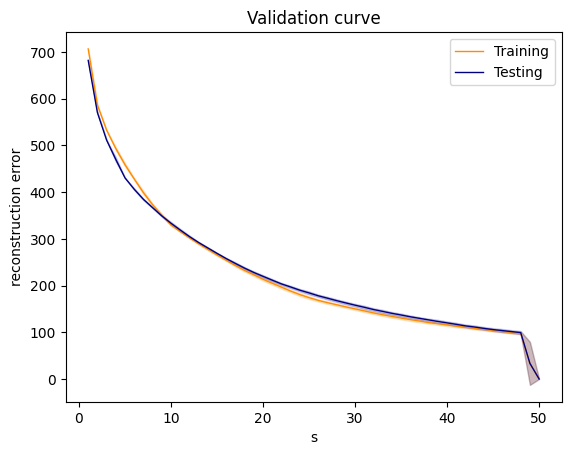

In [9]:
# Visualization CV
#error_cv_drav = sio.loadmat('error_cv_drav_50.mat')["error_drav"]
mean_sd_drav = np.empty((2,2,50))

for i in range(50):
    mean_sd_drav[0,0,i] = np.mean(error_cv_drav[0,i,:]) # training
    mean_sd_drav[1,0,i] = np.mean(error_cv_drav[1,i,:]) # test

    mean_sd_drav[0,1,i] = np.std(error_cv_drav[0,i,:]) # training
    mean_sd_drav[1,1,i] = np.std(error_cv_drav[1,i,:]) # test

plt.title("Validation curve")
plt.xlabel('s')
plt.ylabel('reconstruction error')
param_range = range(1,51)

lw = 1
plt.plot(param_range, mean_sd_drav[0,0,:], label="Training", color="darkorange", lw=lw)
plt.fill_between(param_range,
    mean_sd_drav[0,0,:] - mean_sd_drav[0,1,:],
    mean_sd_drav[0,0,:] + mean_sd_drav[0,1,:],
    alpha=0.2,
    color="darkorange",
    lw=lw)

plt.plot(param_range, mean_sd_drav[1,0,:], label="Testing", color="navy", lw=lw)
plt.fill_between(param_range,
    mean_sd_drav[1,0,:] - mean_sd_drav[1,1,:],
    mean_sd_drav[1,0,:] + mean_sd_drav[1,1,:],
    alpha=0.2,
    color="navy",
    lw=lw)

plt.legend(loc="best")
plt.show()

In [12]:
s_opt = 27 # = 26 + 1 (start of range: 1 -> index + 10)
print(min(abs(mean_sd_drav[0,0,:42])))
print(np.argmin(abs(mean_sd_drav[0,0,:42])))
#print(error_cv_drav[0,19,:])

110.84872862645827
41


### KL divergence

In [ ]:
# KL divergence -> most stable W
W_opt_drav = kl_divergence(data=data, target="W", n_comp=27, n_iter=250, name_mat="W_list_drav")
sio.savemat("W_opt_drav.mat", dict(W_opt_drav=W_opt_drav))

In [16]:
W_opt_drav = sio.loadmat("W_opt_drav.mat", simplify_cells=True)["W_opt_drav"]

In [ ]:
# KL divergence -> most stable W
H_opt_drav = kl_divergence(data=data, target="H", n_comp=27, n_iter=250, name_mat="H_list_drav")
sio.savemat("H_opt_drav.mat", dict(H_opt_drav=H_opt_drav))

In [17]:
H_opt_drav = sio.loadmat("H_opt_drav.mat", simplify_cells=True)["H_opt_drav"]

In [ ]:
W_list = sio.loadmat("W_list_drav.mat")["W_list"]
colorbar(plt.matshow(W_list[1]))

### Consensus matrix + HC

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

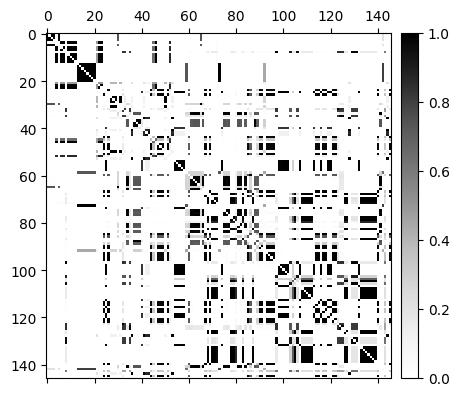

In [85]:
C_W = consensusCluster(data=data, target="W", n_comp=10, n_iter=250, name_mat="C_W_original", plot=True)

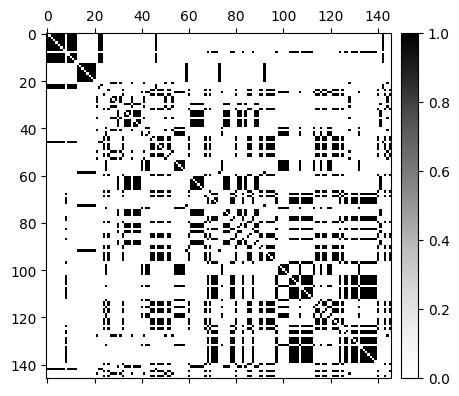

In [87]:
C_W = consensusCluster(data=data, target="W", n_comp=10, n_iter=250, name_mat="C_W_original", plot=True)

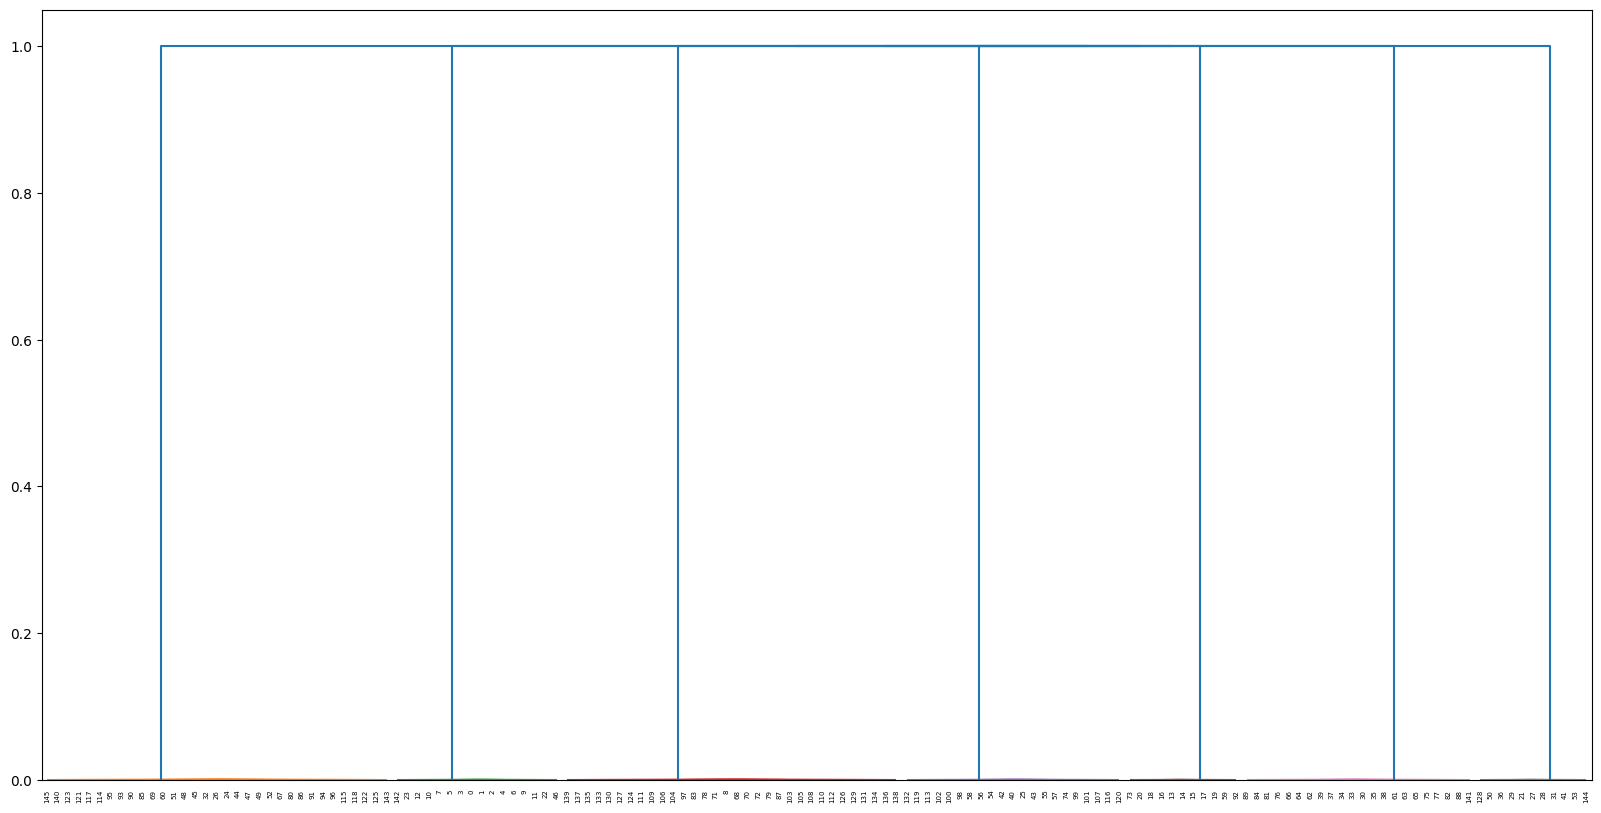

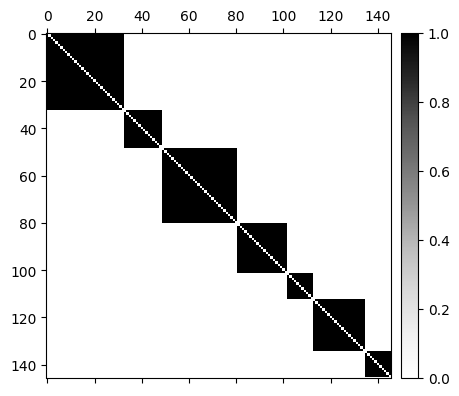

In [88]:
# Consensus matrix for W
#C_W = consensusCluster(data=data, target="W", n_comp=s_opt, n_iter=250, name_mat="C_W_original", plot=True)
#C_W = sio.loadmat("C_W_original.mat")["M"]


# average linkage HC
Z = linkage(y=1-C_W[np.triu_indices(data.shape[0], k=1)],
            method='average', metric='euclidean', optimal_ordering=True)
fig = plt.figure(figsize=(20, 10))
dn = dendrogram(Z)
plt.show()

HC_C = np.argsort(fcluster(Z, t=s_opt, criterion='maxclust'))
C_W_reord = C_W[HC_C][:,HC_C] # reordered consensus matrix according to HC
colorbar(plt.matshow(C_W_reord, cmap="Greys"))
plt.show()

### Cophenetic correlation coefficient

In [89]:
# Cophenetic correlation coefficient
# distance matrices (Brunet et al.)
# 1. np.ones_like(C)-C
# 2. linkage used in reordering C
#Z1 = linkage(y=C_W[np.triu_indices(data.shape[0], k=1)], method='average', metric='euclidean', optimal_ordering=True)
#coph_W, _ = cophenet(Z1, np.ones_like(C_W_triu)-C_W_triu)
coph_W, _ = cophenet(Z, 1-C_W[np.triu_indices(data.shape[0], k=1)])
print(coph_W)

# TO DO:
# reason for negative coph -> coph calculation
# plot of coph vs s -> choosing s_opt

1.0


#### Plot of coph vs s

In [ ]:
# coph vs s
coph_list = list()

for s in range(2,25):
    C = consensusCluster(data=data, target="W", n_comp=s, n_iter=50, name_mat=None, plot=False)
    Z = linkage(y=1-C[np.triu_indices(data.shape[0], k=1)],
            method='average', metric='euclidean', optimal_ordering=False)
    coph_W, _ = cophenet(Z, 1-C[np.triu_indices(data.shape[0], k=1)])
    coph_list.append(coph_W)

sio.savemat("Coph_list.mat", dict(coph_list=coph_list))

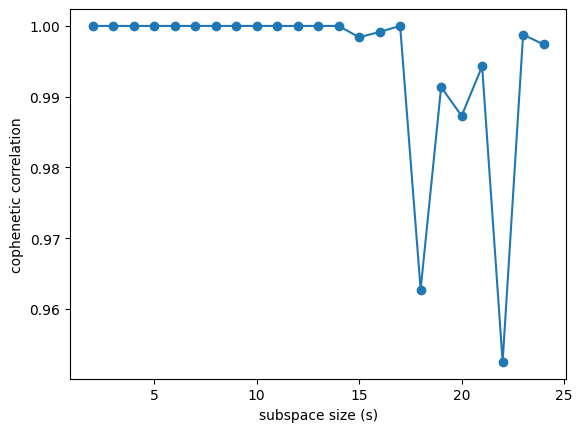

In [ ]:
coph_list = sio.loadmat("Coph_list.mat")["coph_list"]
plt.plot(list(range(2,25)), coph_list.T, "-o")
plt.xlabel("subspace size (s)")
plt.ylabel("cophenetic correlation")
plt.show()

# unreliable clustering for s = 18, 22

In [ ]:
coph_list

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.99839299, 0.99915497,
        1.        , 0.96272913, 0.99135857, 0.98728839, 0.99428849,
        0.95250978, 0.99878285, 0.99737575]])

### Consensus, CPCC for H

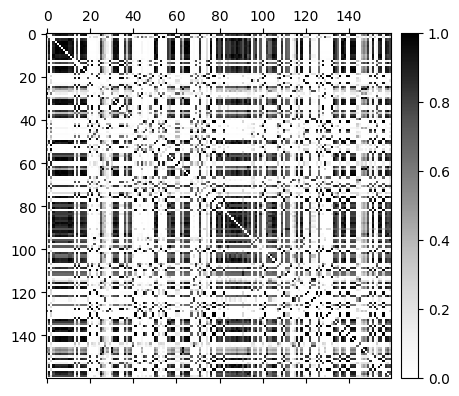

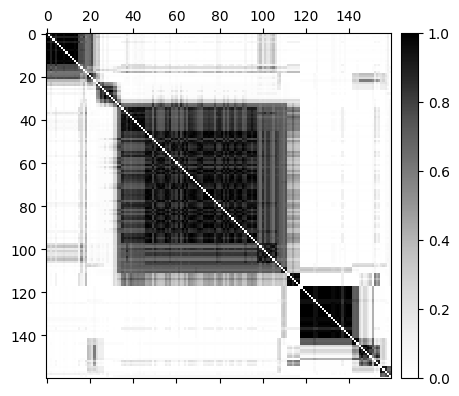

0.9762674550636544


In [20]:
# Consensus clustering + cophenetic coefficient for H
# Consensus matrix
#C_H = consensusCluster(data=data, target="H", n_comp=s_opt, n_iter=250, name_mat="C_H_original", plot=True)
C_H = sio.loadmat("C_H_original.mat", simplify_cells=True)["M"]
colorbar(plt.matshow(C_H, cmap="Greys"))

# average linkage HC
Z = linkage(y=1-C_H[np.triu_indices(data.shape[1], k=1)], method='average', metric='euclidean', optimal_ordering=True)
#fig = plt.figure(figsize=(20, 10))
#dn = dendrogram(Z)
#plt.show()

HC_C_H = np.argsort(fcluster(Z, t=s_opt, criterion='maxclust'))
C_H_reord = C_H[HC_C_H][:,HC_C_H] # reordered consensus matrix according to HC
colorbar(plt.matshow(C_H_reord, cmap="Greys"))
plt.show()

# Cophenetic correlation coefficient
# distances matrices: np.ones_like(M)-M;
#Z1 = linkage(y=C_H_reord[np.triu_indices(data.shape[1], k=1)], method='average', metric='euclidean', optimal_ordering=True)
coph_H, _ = cophenet(Z, 1-C_H[np.triu_indices(data.shape[1], k=1)])
print(coph_H)


In [ ]:
# coph vs s
coph_H_list = list()

for s in range(2,25):
    C = consensusCluster(data=data, target="H", n_comp=s, n_iter=50, name_mat=None, plot=False)
    Z = linkage(y=1-C[np.triu_indices(data.shape[0], k=1)],
            method='average', metric='euclidean', optimal_ordering=False)
    coph_H, _ = cophenet(Z, 1-C[np.triu_indices(data.shape[0], k=1)])
    coph_H_list.append(coph_H)

sio.savemat("Coph_H_list.mat", dict(coph_H_list=coph_H_list))

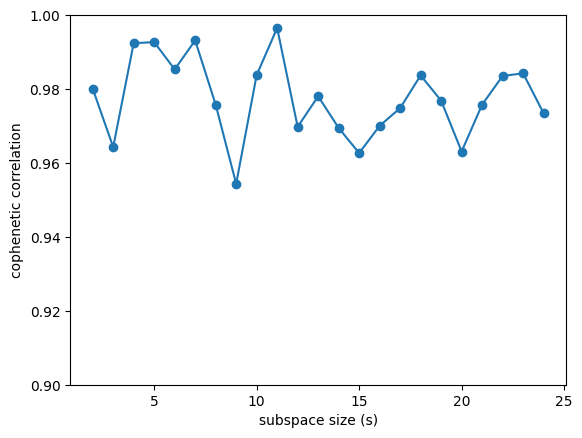

In [90]:
coph_H_list = sio.loadmat("Coph_H_list.mat")["coph_H_list"]
plt.plot(list(range(2,25)), coph_H_list.T, "-o")
plt.ylim([0.9, 1])
plt.xlabel("subspace size (s)")
plt.ylabel("cophenetic correlation")
plt.show()

# unreliable clustering for s = 3, 9, 15, 20

In [ ]:
coph_H_list

### Scrambling odor profiles

In [21]:
# NMF on scrambled odor profiles
# 1: odorants: columns per row
data_rand_cols = np.copy(data)
# 2: descriptors: rows per column
data_rand_rows = np.copy(data)
# 3: 1 & 2
data_rand_compl = np.copy(data)

for i in range(146):
    data_rand_cols[i,:] = np.random.permutation(data_rand_cols[i,:])
    data_rand_compl[i,:] = np.random.permutation(data_rand_compl[i,:])

for j in range(160):
    data_rand_rows[:,j] = np.random.permutation(data_rand_rows[:,j])
    data_rand_compl[:,j] = np.random.permutation(data_rand_compl[:,j])

# NMF
config = dict(n_components=s_opt, init='random', solver='cd', beta_loss='frobenius',
              tol=0.0001, max_iter=1000, random_state=None, alpha_W=0.01, alpha_H='same',
              l1_ratio=0.1, verbose=0, shuffle=False)

model_rand_cols = NMF(**config)
H_rand_cols = model_rand_cols.fit_transform(data_rand_cols.T).T
W_rand_cols = model_rand_cols.components_.T

model_rand_rows = NMF(**config)
H_rand_rows = model_rand_rows.fit_transform(data_rand_rows.T).T
W_rand_rows = model_rand_rows.components_.T

model_rand_compl = NMF(**config)
H_rand_compl = model_rand_compl.fit_transform(data_rand_compl.T).T
W_rand_compl = model_rand_compl.components_.T

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


In [22]:
C_rand_cols = sio.loadmat("C_rand_cols.mat")["M"]
C_rand_rows = sio.loadmat("C_rand_rows.mat")["M"]
C_rand_compl = sio.loadmat("C_rand_compl.mat")["M"]

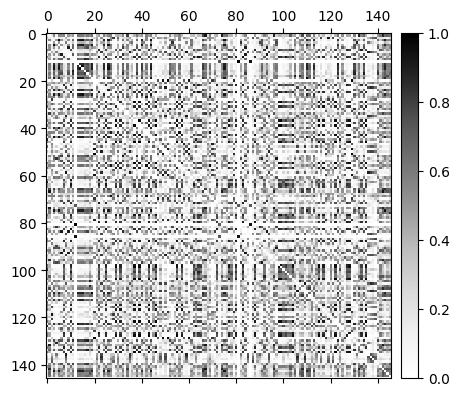

In [ ]:
# Consensus clustering (shuffled odorants)
C_rand_cols = consensusCluster(data=data_rand_cols, n_comp=s_opt, n_iter=250, name_mat="C_rand_cols", plot=True)

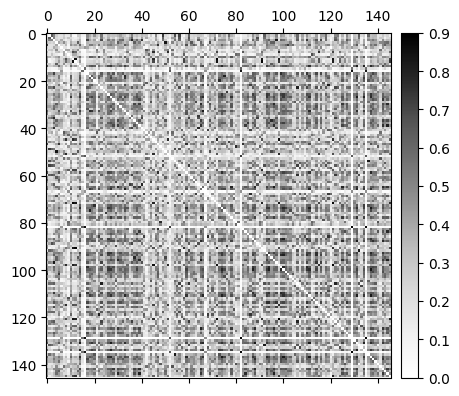

In [ ]:
# Consensus clustering (shuffled descriptors)
C_rand_rows = consensusCluster(data=data_rand_rows, n_comp=s_opt, n_iter=250, name_mat="C_rand_rows", plot=True)

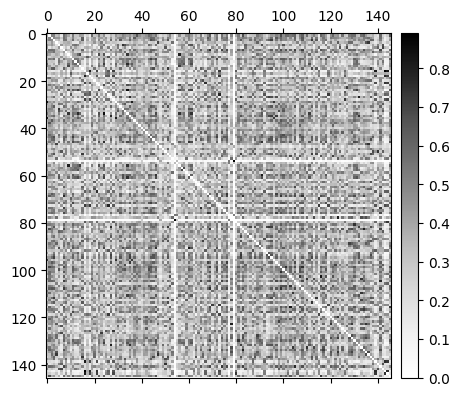

In [ ]:
# Consensus clustering (completely shuffled)
C_rand_compl = consensusCluster(data=data_rand_compl, n_comp=s_opt, n_iter=250, name_mat="C_rand_compl", plot=True)

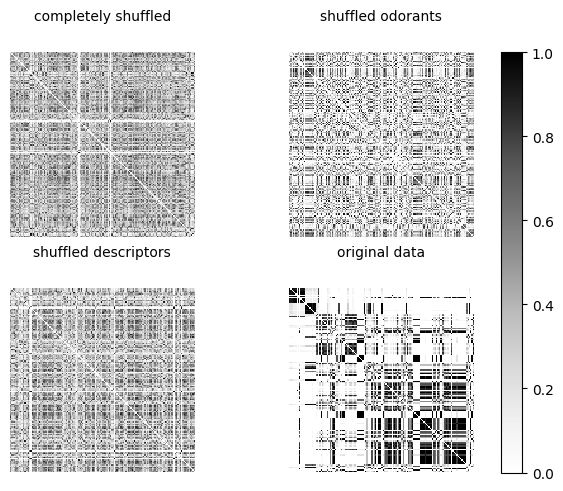

In [23]:
# Consensus matrices for shuffled and original data
fig, axs = plt.subplots(2,2, layout="constrained")
matrices = [C_rand_compl, C_rand_cols, C_rand_rows, C_W]
titles = ["completely shuffled", "shuffled odorants", "shuffled descriptors", "original data"]
for (ax, mat, title) in zip(axs.flat, matrices, titles):
    im = ax.matshow(mat, cmap="Greys")
    ax.axis("off")
    ax.set_title(title, fontsize=10)
fig.colorbar(im, ax=axs)
plt.savefig("Consensus shuffled vs original (Drav).png")
plt.show()

# TO DO
# titles (position)

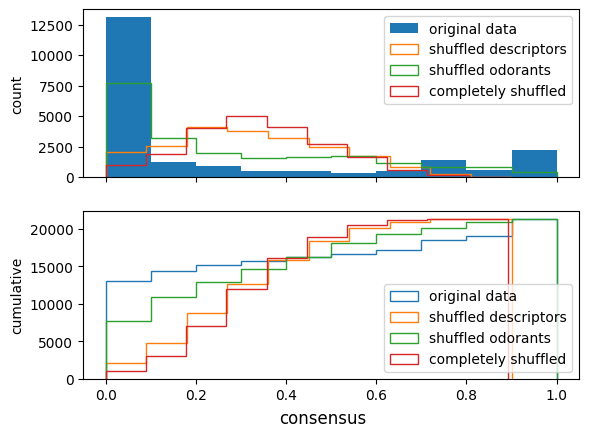

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.hist(C_W.flatten(), label="original data")
ax1.hist(C_rand_rows.flatten(), histtype="step", label="shuffled descriptors")
ax1.hist(C_rand_cols.flatten(), histtype="step", label="shuffled odorants")
ax1.hist(C_rand_compl.flatten(), histtype="step", label="completely shuffled")
ax1.set_ylabel("count")
ax1.legend()

ax2.hist(C_W.flatten(), cumulative=True, histtype="step", label="original data")
ax2.hist(C_rand_rows.flatten(), cumulative=True, histtype="step", label="shuffled descriptors")
ax2.hist(C_rand_cols.flatten(), cumulative=True, histtype="step", label="shuffled odorants")
ax2.hist(C_rand_compl.flatten(), cumulative=True, histtype="step", label="completely shuffled")
ax2.set_ylabel("cumulative")
ax2.legend()

fig.supxlabel("consensus")
#plt.tight_layout()

plt.show()

### Odor space visualization: t-SNE

<ipython-input-31-8fa8bb2904e5>:24: UserWarning: The palette list has more values (9) than needed (6), which may not be intended.
  ax = sns.scatterplot(x="tsne_1", y="tsne_2", data=W_embedded, hue="cluster", palette=cmap)


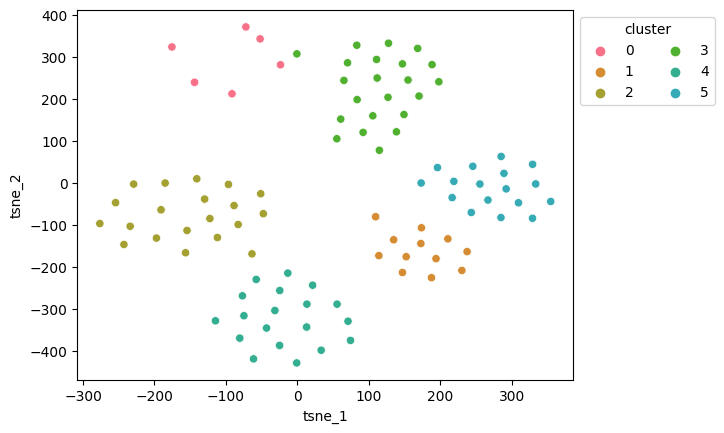

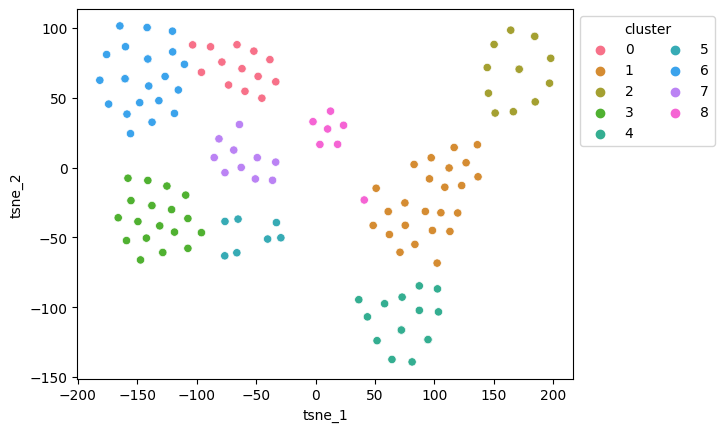

In [31]:
# Visualization (t-SNE: default parameters)

config_tsne = dict(n_components=2, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto',
              n_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean',
              metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut',
              angle=0.5, n_jobs=None)

config_kmeans_W = dict(n_clusters=6, init='k-means++', n_init='auto', max_iter=300,
                  tol=1e-4, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
config_kmeans_H = dict(n_clusters=9, init='k-means++', n_init='auto', max_iter=300,
                  tol=1e-4, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

tsne_W = TSNE(**config_tsne).fit_transform(C_W_reord)
kmeans_W = KMeans(**config_kmeans_W).fit(tsne_W)
W_embedded = pd.DataFrame({"tsne_1": tsne_W[:,0], "tsne_2": tsne_W[:,1], "cluster": kmeans_W.labels_})
W_embedded["cluster"] = W_embedded["cluster"].astype("category")

tsne_H = TSNE(**config_tsne).fit_transform(C_H_reord)
kmeans_H = KMeans(**config_kmeans_H).fit(tsne_H)
H_embedded = pd.DataFrame({"tsne_1": tsne_H[:,0], "tsne_2": tsne_H[:,1], "cluster": kmeans_H.labels_})
H_embedded["cluster"] = H_embedded["cluster"].astype("category", copy=False)

cmap = sns.color_palette("husl", 9)
ax = sns.scatterplot(x="tsne_1", y="tsne_2", data=W_embedded, hue="cluster", palette=cmap)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.show()

ax = sns.scatterplot(x="tsne_1", y="tsne_2", data=H_embedded, hue="cluster", palette=cmap)
ax.set_facecolor("none")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2)
plt.show()

# TO DO
# kMeans parameters: n_clusters
# legend: ncol

In [32]:
def color_cols(data):
    df = pd.DataFrame().reindex_like(data)
    for i, col in enumerate(data):
        df[col] = "color: {}".format(cmap[i])
    return df

In [34]:
# table of corresponding descriptors or odorants
cmap = cmap.as_hex()
cluster_W = np.stack((kmeans_W.labels_, descriptors_str), axis=1)
cluster_H = np.stack((kmeans_H.labels_, odorants_str), axis=1)
descriptors = dict()
odorants = dict()

for i in range(6):
    descriptors["Cluster {}".format(i+1)] = list(cluster_W[cluster_W[:,0] == i,1])
for i in range(9):
    odorants["Cluster {}".format(i+1)] = list(cluster_H[cluster_H[:,0] == i,1])

max_len_descr = max(len(elem) for elem in descriptors.values())
for cluster in descriptors.values():
    cluster.extend(['']*(max_len_descr - len(cluster)))

max_len_odor = max(len(elem) for elem in odorants.values())
for cluster in odorants.values():
    cluster.extend(['']*(max_len_odor - len(cluster)))

descriptors = pd.DataFrame(descriptors)
descriptors.style.apply(color_cols, axis=None)


,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
0,"ANISE, LICORICE","FRUITY,CITRUS",FRESH TOBACCO SMOKE,SEASONING FOR MEAT,PAINT,ROSE
1,ALCOHOLIC,LEMON,INCENSE,BLACK PEPPER,VARNISH,VIOLETS
2,"ETHERISH, ANAESTHETIC",GRAPEFRUIT,COFFEE,GREEN PEPPER,POPCORN,LAVENDER
3,CLEANING FLUID,ORANGE,STALE TOBACCO SMOKE,DILL,FRIED CHICKEN,COLOGNE
4,"GASOLINE, SOLVENT","FRUITY,OTHER THAN CITRUS",BURNT PAPER,CARAWAY,"MEATY ( COOKED,GOOD)",MUSK
5,"TURPENTINE, PINE OIL",PINEAPPLE,BURNT MILK,"OAK WOOD,COGNAC",SOUPY,PERFUMERY
6,GERANIUM LEAVES,GRAPE JUICE,BURNT RUBBER,"WOODY, RESINOUS",COOKED VEGETABLES,FRAGRANT
7,CELERY,STRAWBERRY,TAR,CEDARWOOD,RANCID,AROMATIC
8,FRESH GREEN VEGETABLES,"APPLE, FRUIT",CREOSOTE,MOTHBALLS,SWEATY,HONEY
9,CRUSHED WEEDS,PEAR,"DISINFECTANT, CARBOLIC","MINTY, PEPPERMINT",CHEESY,"CHERRY, BERRY"


In [35]:
odorants = pd.DataFrame(odorants)
odorants.style.apply(color_cols, axis=None)

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
0,Cresol-p_high,ButylQuinolineiso_high,PropylButyrate_high,DiethylSulfide_high,Abhexone_high,Coumarin_high,"Decadienal2,4-trans-trans_high",CresylMethylEther-p_high,Citral_high
1,CresylAcetate-p_high,ButylSulfide_high,PropylQuinoline-iso_high,DimethylPhenylEthylCarb_high,Acetophenone_high,Cresol-m_high,DecahydroNaphthalene_high,MethylAnthranilate_high,PhenylAceticAcid_high
2,CresylisoButyrate-p_high,Camphordl_high,PropylSulfide_high,"DimethylPyrazine2,3_high",AcetylPyridine_high,Nootkatone_high,DibutylAmine_high,MethylFuroate_high,PhenylAcetylene_high
3,CuminicAldehyde_high,Carvone-l_high,Pyridine_high,"DimethylPyrazine2,5_high",Adoxal_high,Octanol1_high,DimethylBenzylCarbinylBut_high,MethylQuinolinepara_high,PhenylEthanolhighconc_high
4,Cyclocitral-iso_high,Caryophyllene_high,Safrole_high,"DimethylPyrrole2,5_high",AldehydeC-16highcon_high,Octenol-1-3-OL_high,DimethylTrisulfide_high,MethylThiobutyrate_high,PhenylEthanollowconc_low
5,Cyclodithalfarol_high,Cashmeran_high,Sandiff_high,EthylButyrate_high,AldehydeC-16lowcon_low,PentanoicAcid_high,Diola_high,Methylsalicylate_high,Phorone-iso_high
6,"Cyclohexanedione1,2_high",Celeriax_high,Santalol_high,EthylPropionate_high,AldehydeC-18_high,PentenoicAcid4_high,EthylPyrazinelowconc_low,MuskGalaxolide_high,Pinenealpha_high
7,Cyclohexanol_high,Chlorothymol_high,Skatole_high,EthylPyrazinehighconc_high,AllylCaproate_high,,Floralozone_high,MuskTonalid_high,
8,Cyclotene_high,CinnamicAldehyde_high,Terpineolmostlyalpha_high,Eucalyptol_high,AmylAcetateiso-amylAcetat_high,,Furfural_high,Myracaldehyde_high,
9,Cyclotropal_high,Citralva_high,TetrahydroThiophene_high,Eugenol_high,AmylButyrate_high,,FurfurylMercaptan_high,NonylAcetate_high,


### PCA

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

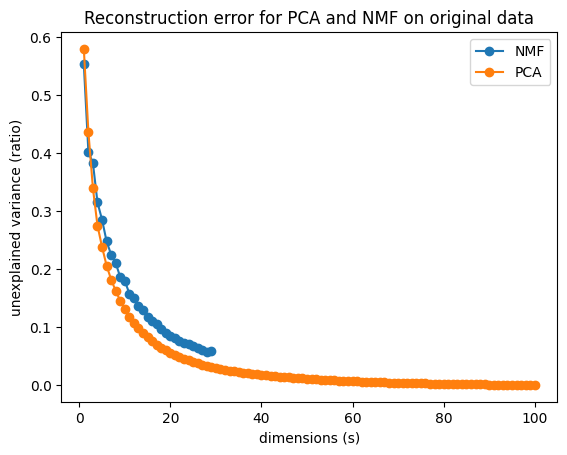

In [ ]:
# PCA (original data)
unexpl_var_NMF = list()
for s in range(1,30):
    model = NMF(n_components=s, init='random', solver='cd', beta_loss='frobenius',
                tol=1e-4, max_iter=200, random_state=None, alpha_W=0.01, alpha_H='same',
                l1_ratio=0.1, verbose=0, shuffle=False)
    H = model.fit_transform(X=data.T).T
    W = model.components_.T
    unexpl_var_NMF.append(1-explained_variance_score(data, W@H)) # similar to 1 - R^2

unexpl_var_PCA = list()
for s in range(1,101):
    model = PCA(n_components=s, copy=True, whiten=False, svd_solver='auto',
                tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto',
                random_state=None)
    model.fit_transform(data)
    unexpl_var_PCA.append(1-np.sum(model.explained_variance_ratio_))

plt.plot(list(range(1,30)), unexpl_var_NMF, "-o", label="NMF")
plt.plot(list(range(1,101)), unexpl_var_PCA, "-o", label="PCA")
plt.title("Reconstruction error for PCA and NMF on original data")
plt.xlabel("dimensions (s)")
plt.ylabel("unexplained variance (ratio)")
plt.legend()
plt.show()

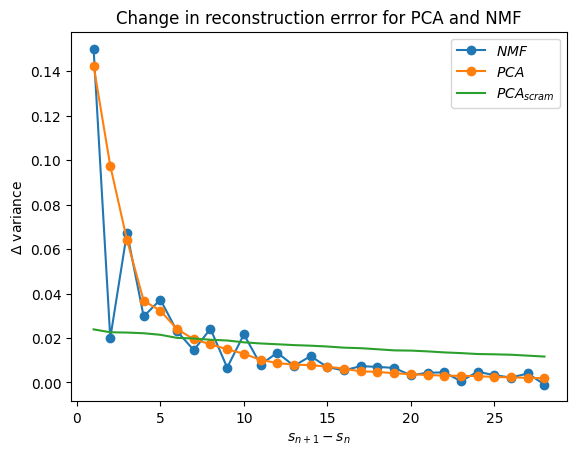

In [ ]:
# PCA (scrambled data)
unexpl_var_PCA_scram = list()

for s in range(1,30):
    model = PCA(n_components=s, copy=True, whiten=False, svd_solver='auto',
                tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto',
                random_state=None)
    model.fit(data_rand_compl)     # shuffled descriptors & odors
    unexpl_var_PCA_scram.append(1-np.sum(model.explained_variance_ratio_))

plt.plot(list(range(1,29)), [unexpl_var_NMF[i-1] - unexpl_var_NMF[i] for i in range(1,29)], "-o", label="$NMF$")
plt.plot(list(range(1,29)), [unexpl_var_PCA[i-1] - unexpl_var_PCA[i] for i in range(1,29)], "-o", label="$PCA$")
plt.plot(list(range(1,29)), [unexpl_var_PCA_scram[i-1] - unexpl_var_PCA_scram[i] for i in range(1,29)], label="$PCA_{scram}$")
plt.title("Change in reconstruction errror for PCA and NMF")
plt.xlabel("$s_{n+1} - s_n$")
plt.ylabel("$\Delta$ variance")
plt.legend()
plt.show()

In [69]:
# temporarily 10-dim NMF
s_opt = 10

model = NMF(n_components=s_opt, init=None, solver='cd', beta_loss='frobenius',
            tol=0.0001, max_iter=1000, random_state=None, alpha_W=0.01, alpha_H='same',
            l1_ratio=0.1, verbose=0, shuffle=False)
H10 = model.fit_transform(X=data.T).T # sklearn: exchange of W & H
W10 = model.components_.T

#W10 = kl_divergence(data, target="W", n_comp=s_opt, n_iter=250, name_mat="W_list_10")
#H10 = kl_divergence(data, target="H", n_comp=s_opt, n_iter=250, name_mat="H_list_10")
sio.savemat("W10.mat", dict(W10=W10))
sio.savemat("H10.mat", dict(H10=H10))

In [91]:
W10 = sio.loadmat("W10.mat")["W10"]
H10 = sio.loadmat("H10.mat")["H10"]

### Properties of W

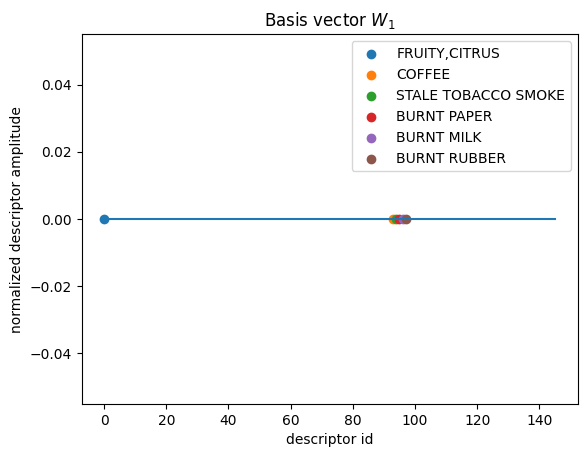

In [92]:
W_opt_drav = W10 # temp

W_normal = normalize(W_opt_drav, axis=0) # normalized basis vectors
#print(np.linalg.norm(W_normal[:,0]))

plt.title("Basis vector $W_1$")
plt.xlabel("descriptor id")
plt.ylabel("normalized descriptor amplitude")
plt.plot(list(range(data.shape[0])), W_normal[:,0])

for max_id in np.argsort(-W_normal[:,0])[:6]:
    plt.scatter(max_id, W_normal[max_id,0],
        label=descriptors_str[max_id])
plt.legend()
plt.show()

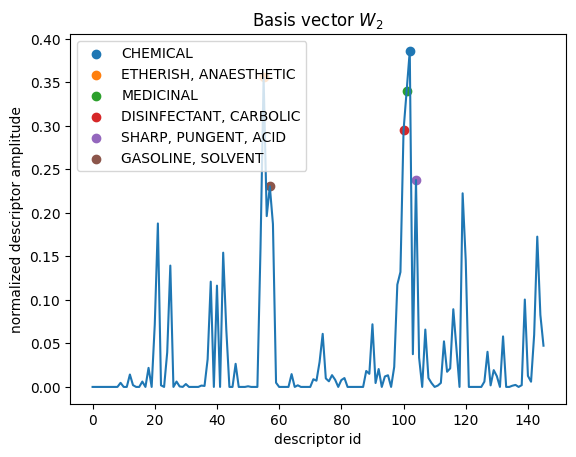

In [38]:
plt.title("Basis vector $W_2$")
plt.xlabel("descriptor id")
plt.ylabel("normalized descriptor amplitude")
plt.plot(list(range(data.shape[0])), W_normal[:,1])
#plt.scatter(np.argmax(W_normal[:,1]), W_normal[np.argmax(W_normal[:,1]),1],
#            c='r', label=descriptors_str[np.argmax(W_normal[:,1])])
for max_id in np.argsort(-W_normal[:,1])[:6]:
    plt.scatter(max_id, W_normal[max_id,1],
        label=descriptors_str[max_id])
plt.legend()
plt.show()

# argmax = 19 -> sweet
#print(np.argmax(W_normal[:,1]))
#print(odorkey_str[20]) # kept indices -> 19+1

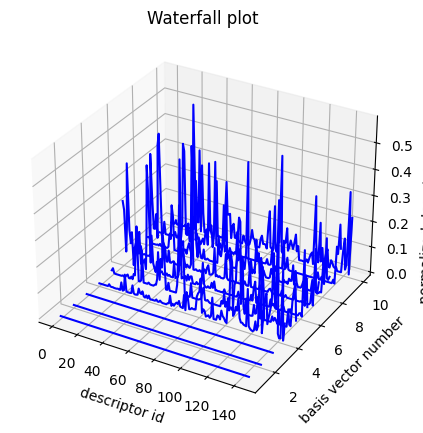

In [54]:
# Waterfall (original data)
ax = plt.figure(figsize=(20,5)).add_subplot(projection='3d')

for i in range(10):
    ax.plot(list(range(data.shape[0])), W_normal[:,i], zs=i+1, zdir='y', color='b')

ax.set_title('Waterfall plot')
ax.set_xlabel('descriptor id')
ax.set_ylabel('basis vector number')
ax.set_zlabel('normalized descriptor amplitude')
plt.savefig("waterfall.png")
plt.show()

# TO DO
# cut off y-label

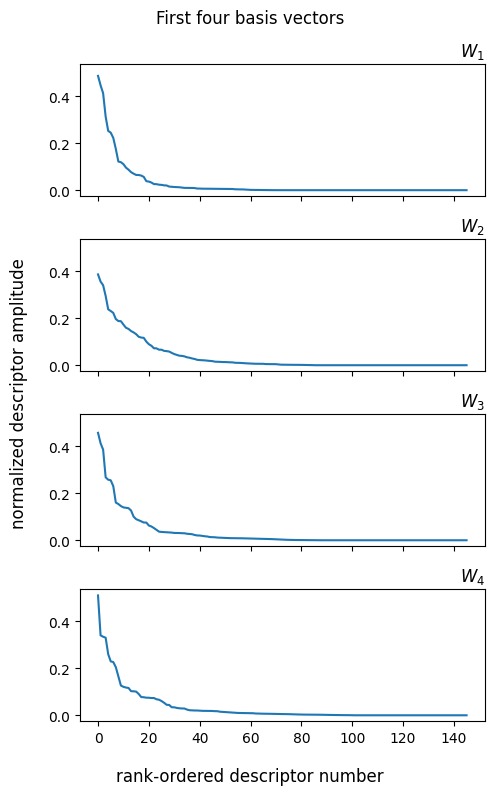

In [40]:
# rank-ordered descriptor amplitudes
fig, axs = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(5,8))

for i, ax in enumerate(axs.flat):
    ax.plot(list(range(data.shape[0])), sorted(W_normal[:,i], reverse=True))
    ax.set_title("$W_{}$".format(i+1), loc='right')

fig.suptitle("First four basis vectors")
fig.supxlabel("rank-ordered descriptor number")
fig.supylabel("normalized descriptor amplitude")
fig.tight_layout()
plt.show()

# TO DO
# scaling axis

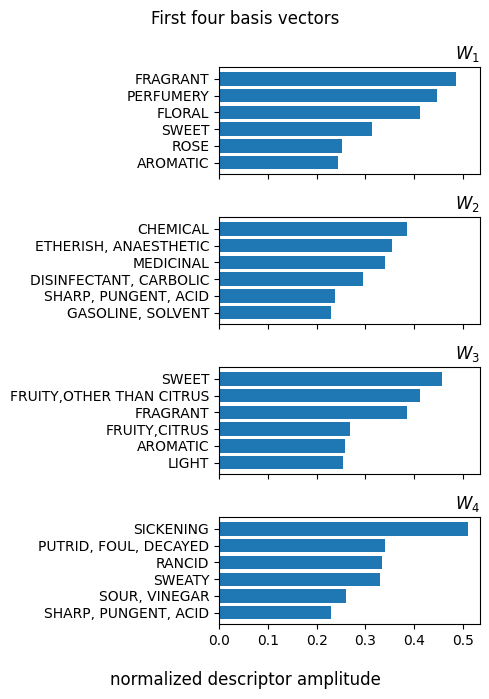

In [41]:
# semantic descriptors of the first six rank-ordered components
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(5,7))

for i, ax in enumerate(axs.flat):
    descriptors_key = np.argsort(-W_normal[:,i])[:6] # 1st six rank-ordered descriptor ids
    descriptors = descriptors_str[descriptors_key]
    ax.barh(descriptors, W_normal[descriptors_key,i])
    ax.set_title("$W_{}$".format(i+1), loc='right')
    #ax.tick_params(axis="y", labelsize=10)
    ax.invert_yaxis()

fig.suptitle("First four basis vectors")
fig.supxlabel("normalized descriptor amplitude")
plt.tight_layout()
plt.show()

In [42]:
# table of 10 largest-valued descriptors
W10_dict = dict()
for i in range(10):
    W10_dict["W{}".format(i+1)] = descriptors_str[np.argsort(-W_normal[:,i])][:10]
W10_dict = pd.DataFrame(W10_dict)

W10_dict

,W1,W2,W3,W4,W5,W6,W7,W8,W9,W10
0,FRAGRANT,CHEMICAL,SWEET,SICKENING,"MINTY, PEPPERMINT","MUSTY, EARTHY, MOLDY","WOODY, RESINOUS","BURNT,SMOKY","GARLIC, ONION",SPICY
1,PERFUMERY,"ETHERISH, ANAESTHETIC","FRUITY,OTHER THAN CITRUS","PUTRID, FOUL, DECAYED","COOL,COOLING","FRUITY,OTHER THAN CITRUS",CEDARWOOD,ALMOND,SICKENING,CINNAMON
2,FLORAL,MEDICINAL,FRAGRANT,RANCID,FRAGRANT,GRAPE JUICE,"HERBAL, GREEN,CUTGRASS","OILY, FATTY",HEAVY,SWEET
3,SWEET,"DISINFECTANT, CARBOLIC","FRUITY,CITRUS",SWEATY,AROMATIC,SWEET,FRAGRANT,HEAVY,"SHARP, PUNGENT, ACID",FRAGRANT
4,ROSE,"SHARP, PUNGENT, ACID",AROMATIC,"SOUR, VINEGAR",SWEET,AROMATIC,LIGHT,"NUTTY, WALNUT ETC.",SULFIDIC,AROMATIC
5,AROMATIC,"GASOLINE, SOLVENT",LIGHT,"SHARP, PUNGENT, ACID","ANISE, LICORICE","CHERRY, BERRY",AROMATIC,"WOODY, RESINOUS","BURNT,SMOKY",CLOVE
6,LIGHT,PAINT,LEMON,HEAVY,MEDICINAL,FRAGRANT,"TURPENTINE, PINE OIL",WARM,HOUSEHOLD GAS,WARM
7,COLOGNE,CLEANING FLUID,ORANGE,"FECAL, LIKE MANURE",CAMPHOR,"WOODY, RESINOUS","BARK,BIRCHBARK",PEANUT BUTTER,"PUTRID, FOUL, DECAYED",HEAVY
8,VIOLETS,AROMATIC,PINEAPPLE,"OILY, FATTY",LIGHT,LAVENDER,CAMPHOR,SWEET,SPICY,ALMOND
9,LAVENDER,"TURPENTINE, PINE OIL","CHERRY, BERRY",ANIMAL,EUCALYPTUS,STRAWBERRY,"DRY, POWDERY",POPCORN,SEWER,"ANISE, LICORICE"


### Structure of H

In [ ]:
s_opt = 10

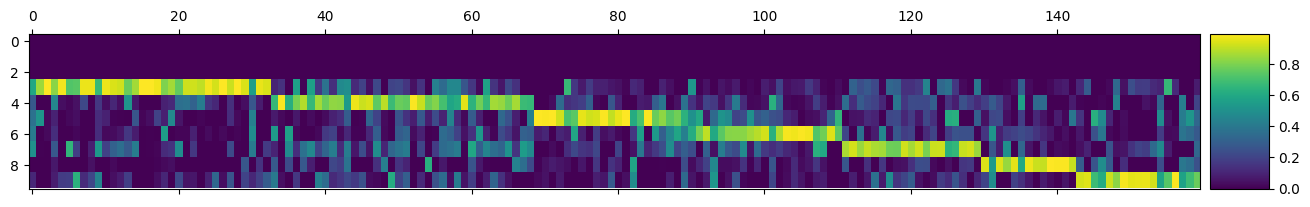

In [71]:
H_normal = normalize(H10, axis=0) # normalized weights

group_id = [j for i in range(s_opt) for j in range(data.shape[1]) if np.argmax(H_normal[:,j]) == i]
H_opt_reord = H_normal[:,group_id]

colorbar(plt.matshow(H_opt_reord, aspect="auto"))
plt.show()

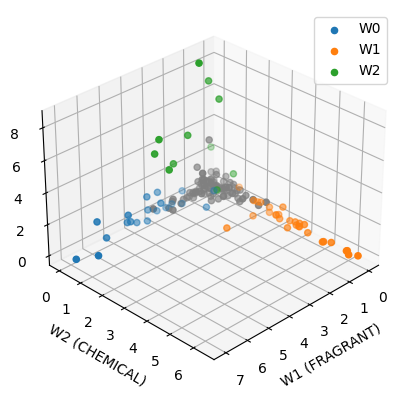

In [44]:
# Odors in space spanned by first three basis vectors
# indices of odors with peak values in W1, W2 or W3
H_opt_drav = H10 # temp

H_peaks = [[j for j in range(data.shape[1]) if np.argmax(H_opt_drav[:,j]) == i] for i in range(3)]
H_peaks_flat = [item for sublist in H_peaks for item in sublist]
# remaining indices
H_remain = [i for i in range(data.shape[1]) if i not in H_peaks_flat]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(H_opt_drav[0,H_remain], H_opt_drav[1,H_remain], H_opt_drav[2,H_remain], color="grey")

for i in range(3):
    ax.scatter(H_opt_drav[0,H_peaks[i]], H_opt_drav[1,H_peaks[i]], H_opt_drav[2,H_peaks[i]], label="W{}".format(i))

ax.set_xlabel('W1 ({})'.format(descriptors_str[np.argsort(-W_normal[:,0])][0]))
ax.set_ylabel('W2 ({})'.format(descriptors_str[np.argsort(-W_normal[:,1])][0]))
ax.set_zlabel('W3 ({})'.format(descriptors_str[np.argsort(-W_normal[:,2])][0]))
ax.view_init(elev=30, azim=45, roll=0)
plt.legend()
plt.savefig("odors 3D.png")
plt.show()


### Bi-clustering

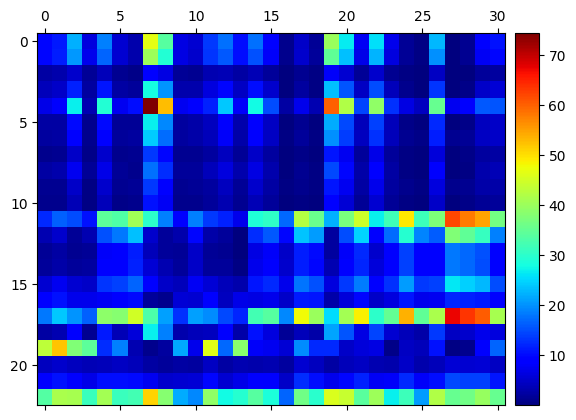

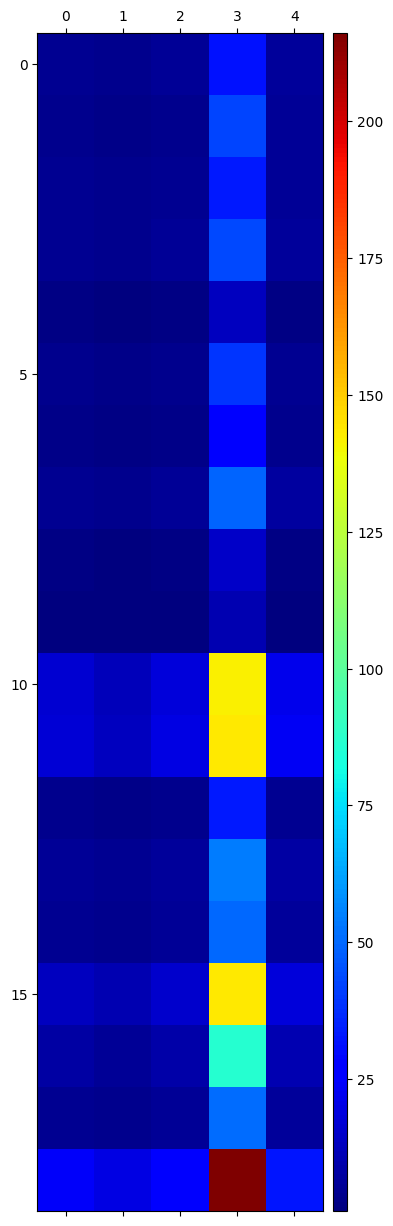

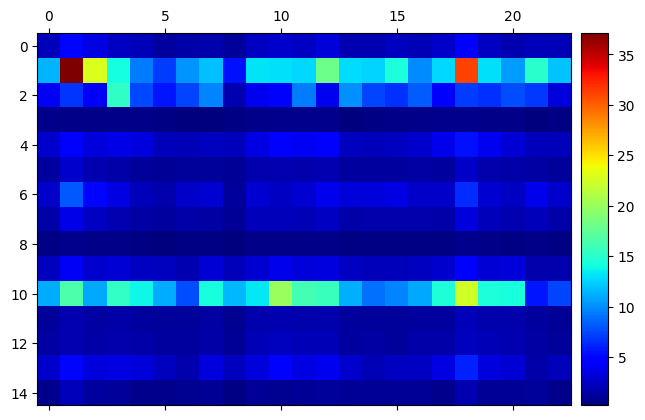

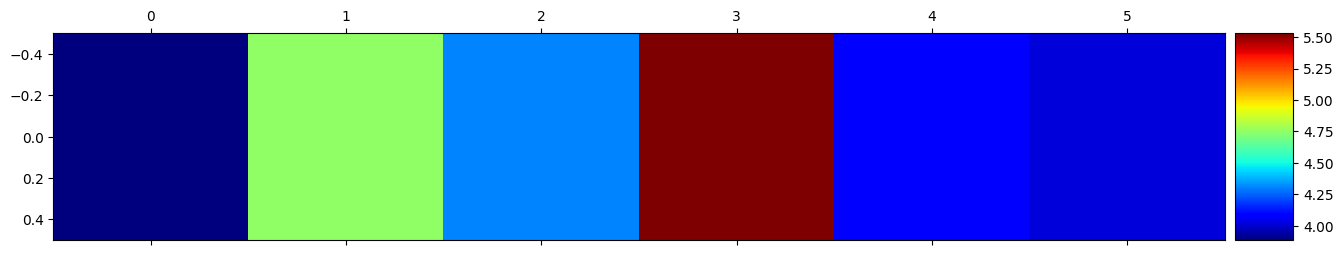

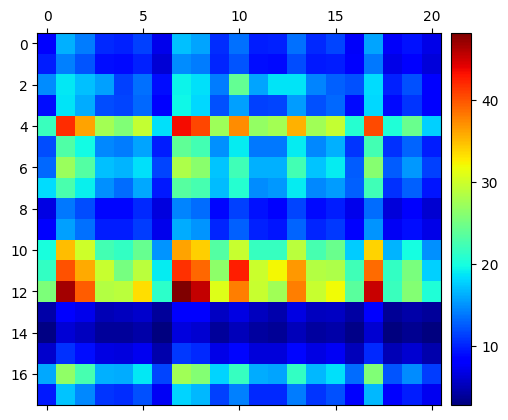

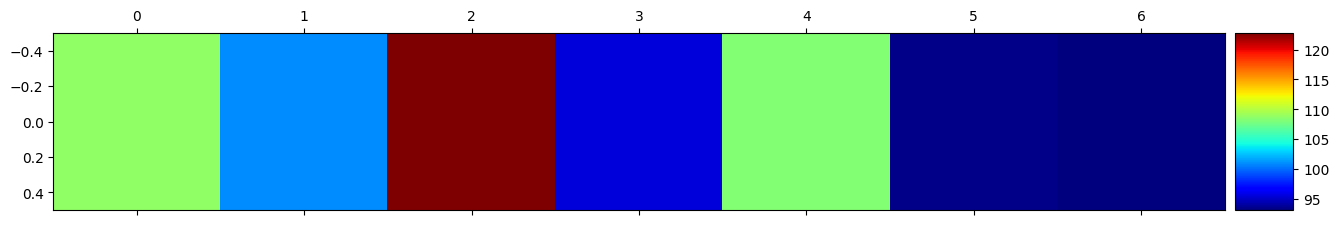

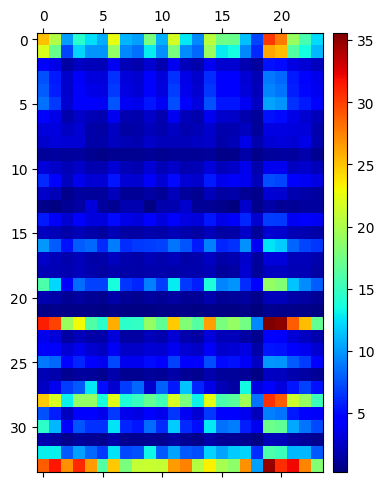

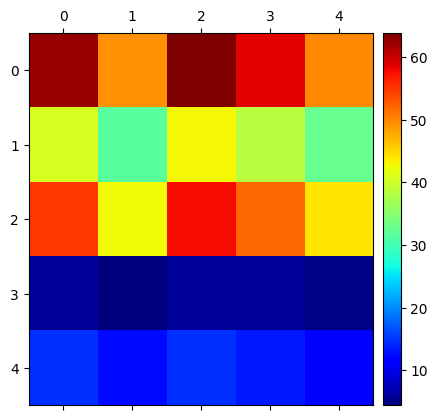

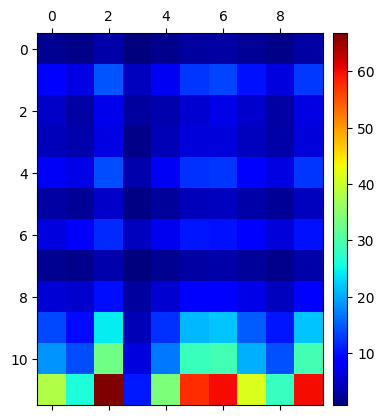

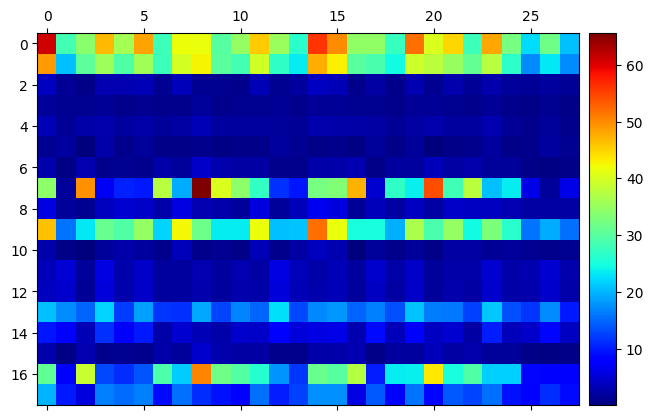

In [45]:
WH = W_opt_drav@H_opt_drav
WH[WH == 0] = 1e-8
WH_cluster = SpectralCoclustering(n_clusters=10, svd_method='randomized', n_svd_vecs=None, mini_batch=False,
                     init='k-means++', n_init=10, random_state=None)

WH_cluster.fit(WH)

for i in range(10):
    submat = WH_cluster.get_submatrix(i, WH)
    #print(submat)
    indices = np.argsort(submat[:,])
    #print(indices)
    #submat_reord = submat[indices][:,indices] # reordered submatrix
    #submat_reord = submat[:,indices]
    #print(submat_reord.shape)
    colorbar(plt.matshow(submat, cmap="jet", aspect="auto"))
    plt.show()

# Problem: SpectralCoclustering verwendet jede Zeile und Spalte nur einmal (Castro: wiederverwendete Zeile, Spalten)

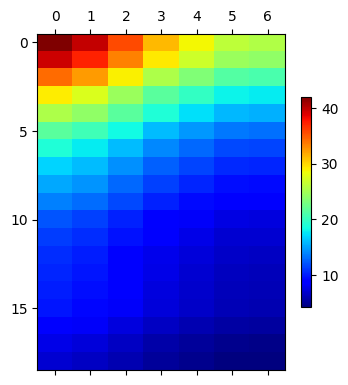

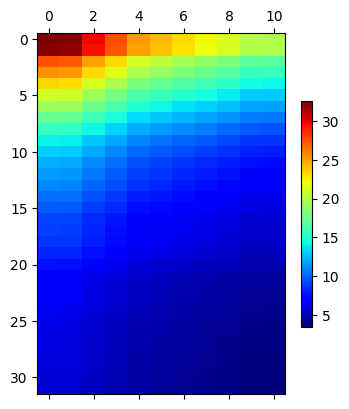

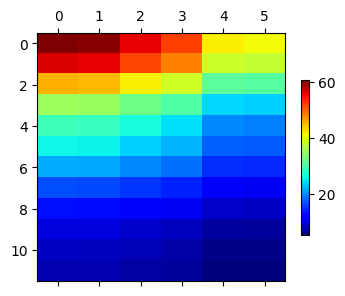

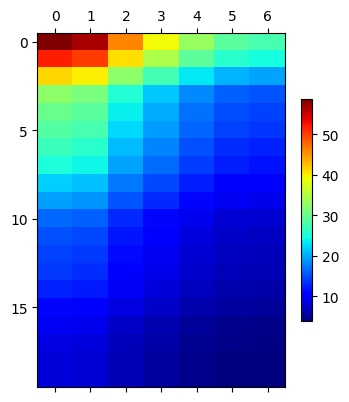

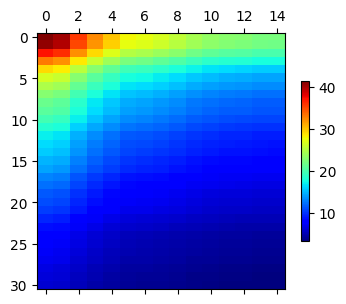

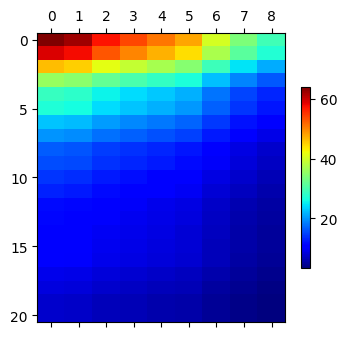

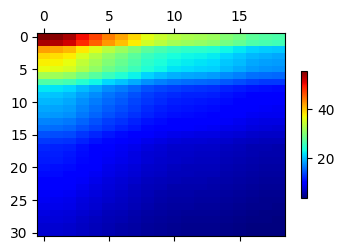

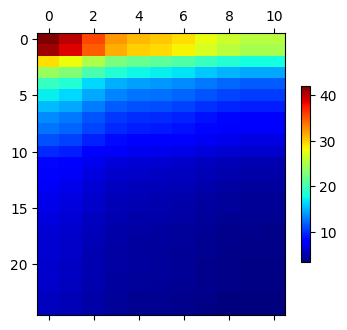

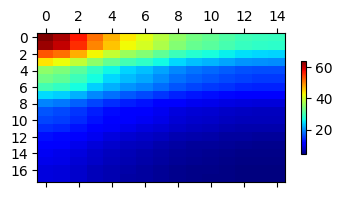

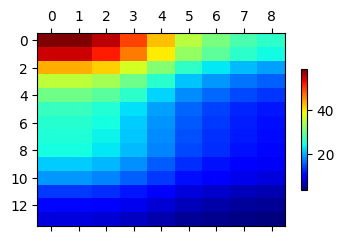

In [ ]:
for i in range(10):
    rows = -np.sort(-W10[:,i])
    rows = rows[rows > 1] # TO DO: limit
    cols = -np.sort(-H10[i,:])
    cols = cols[cols > 3] # TO DO: limit
    mat = np.outer(rows, cols)
    blur = cv2.blur(mat,(3,3)) # 3x3 averaging filter
    plt.colorbar(plt.matshow(blur, cmap="jet", aspect=0.5), shrink=0.25)
    plt.show()

### Shuffled data

In [46]:
# normalized basis vectors
W_normal_cols = normalize(W_rand_cols, axis=0)
W_normal_rows = normalize(W_rand_rows, axis=0)
W_normal_compl = normalize(W_rand_compl, axis=0)

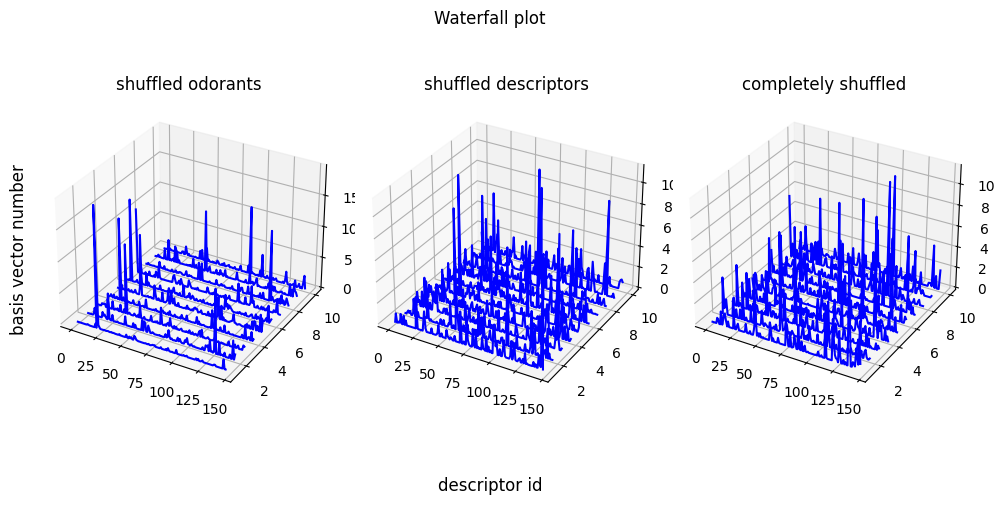

In [47]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(131, projection='3d')
ax1.set_title('shuffled odorants')
ax2 = fig.add_subplot(132, projection='3d')
ax2.set_title('shuffled descriptors')
ax3 = fig.add_subplot(133, projection='3d')
ax3.set_title('completely shuffled')

for i in range(10):
    ax1.plot(list(range(data.shape[0])), W_rand_cols[:,i], zs=i+1, zdir='y', color='b')
    ax2.plot(list(range(data.shape[0])), W_rand_rows[:,i], zs=i+1, zdir='y', color='b')
    ax3.plot(list(range(data.shape[0])), W_rand_compl[:,i], zs=i+1, zdir='y', color='b')

fig.suptitle('Waterfall plot')
fig.supxlabel('descriptor id')
fig.supylabel('basis vector number')
#fig.supzlabel('normalized descriptor amplitude')

plt.tight_layout()
plt.show()

# TO DO
# axis label

#### separate waterfall plots

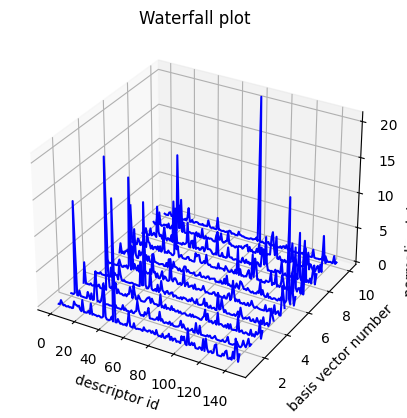

In [ ]:
# Waterfall plot (shuffled odorants)
ax = plt.figure().add_subplot(projection='3d')

for i in range(10):
    ax.plot(list(range(data.shape[0])), W_rand_cols[:,i], zs=i+1, zdir='y', color='b')

ax.set_title('Waterfall plot')
ax.set_xlabel('descriptor id')
ax.set_ylabel('basis vector number')
ax.set_zlabel('normalized descriptor amplitude')
plt.show()

# TO DO
# cut off y-label

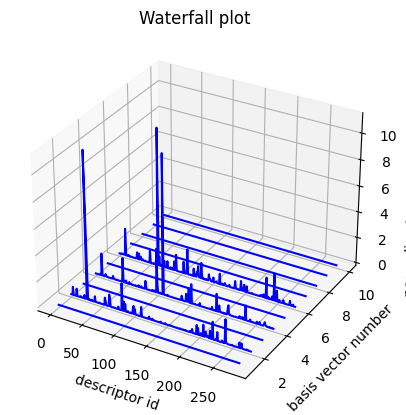

In [ ]:
# Waterfall plot (shuffled descriptors)
ax = plt.figure().add_subplot(projection='3d')

for i in range(10):
    ax.plot(list(range(278)), W_rand_rows[:,i], zs=i+1, zdir='y', color='b')

ax.set_title('Waterfall plot')
ax.set_xlabel('descriptor id')
ax.set_ylabel('basis vector number')
ax.set_zlabel('normalized descriptor amplitude')
plt.show()

# TO DO
# cut off y-label

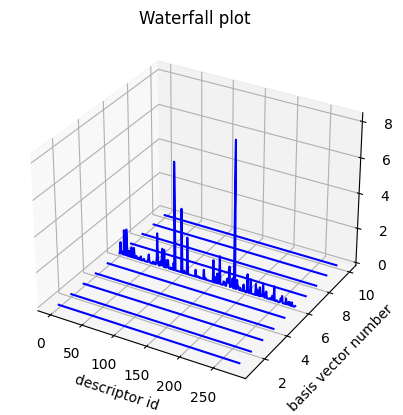

In [ ]:
# Waterfall plot (completely shuffled)
ax = plt.figure().add_subplot(projection='3d')

for i in range(10):
    ax.plot(list(range(278)), W_rand_compl[:,i], zs=i+1, zdir='y', color='b')

ax.set_title('Waterfall plot')
ax.set_xlabel('descriptor id')
ax.set_ylabel('basis vector number')
ax.set_zlabel('normalized descriptor amplitude')
plt.show()

# TO DO
# cut off y-label

### Orthogonality of basis vectors

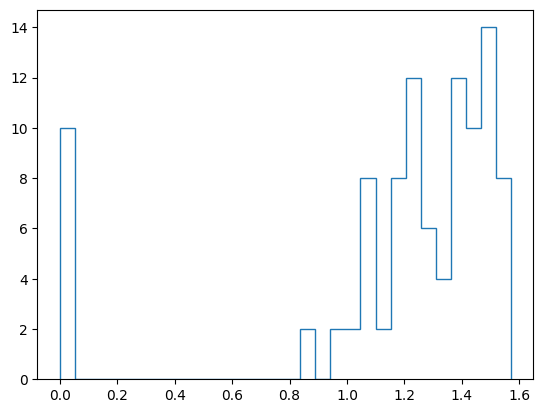

In [48]:
# bar plot
WTW = W_normal.T@W_normal
WTW[WTW > 1] = 1 # round-off error
angles = np.arccos(WTW)
angles = np.ma.array(angles, mask=np.tri(angles.shape[0], k=0)) # masked tril
#print(np.round(angles, 2))
plt.stairs(*np.histogram(angles, bins=30, range=(0,np.pi/2)))
plt.show()

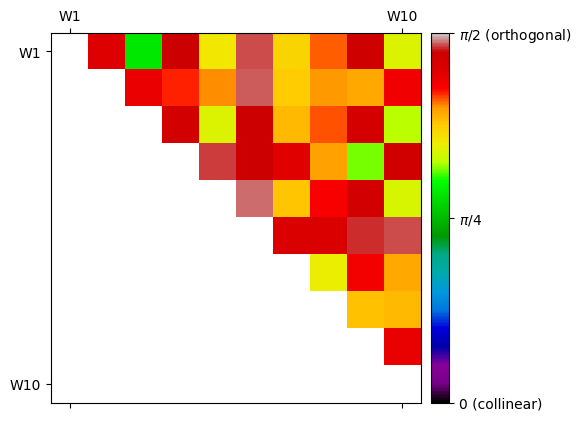

In [50]:
cmap = plt.colormaps.get_cmap("nipy_spectral")
cmap.set_bad("w")

fig, ax = plt.subplots()
mat = ax.matshow(angles, cmap=cmap, vmin=0, vmax=np.pi/2)
ax.set_xticks(ticks=[0,9], labels=["W1", "W10"])
ax.set_yticks(ticks=[0,9], labels=["W1", "W10"])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(mat, cax=cax)
cbar.set_ticks(ticks=[0, np.pi/4, np.pi/2], labels=["0 (collinear)", "$\pi/4$", "$\pi/2$ (orthogonal)"])
plt.show()

## Supporting figures

In [81]:
H_opt_drav = H10
WH = W_opt_drav@H_opt_drav
WH[0,0] = 100

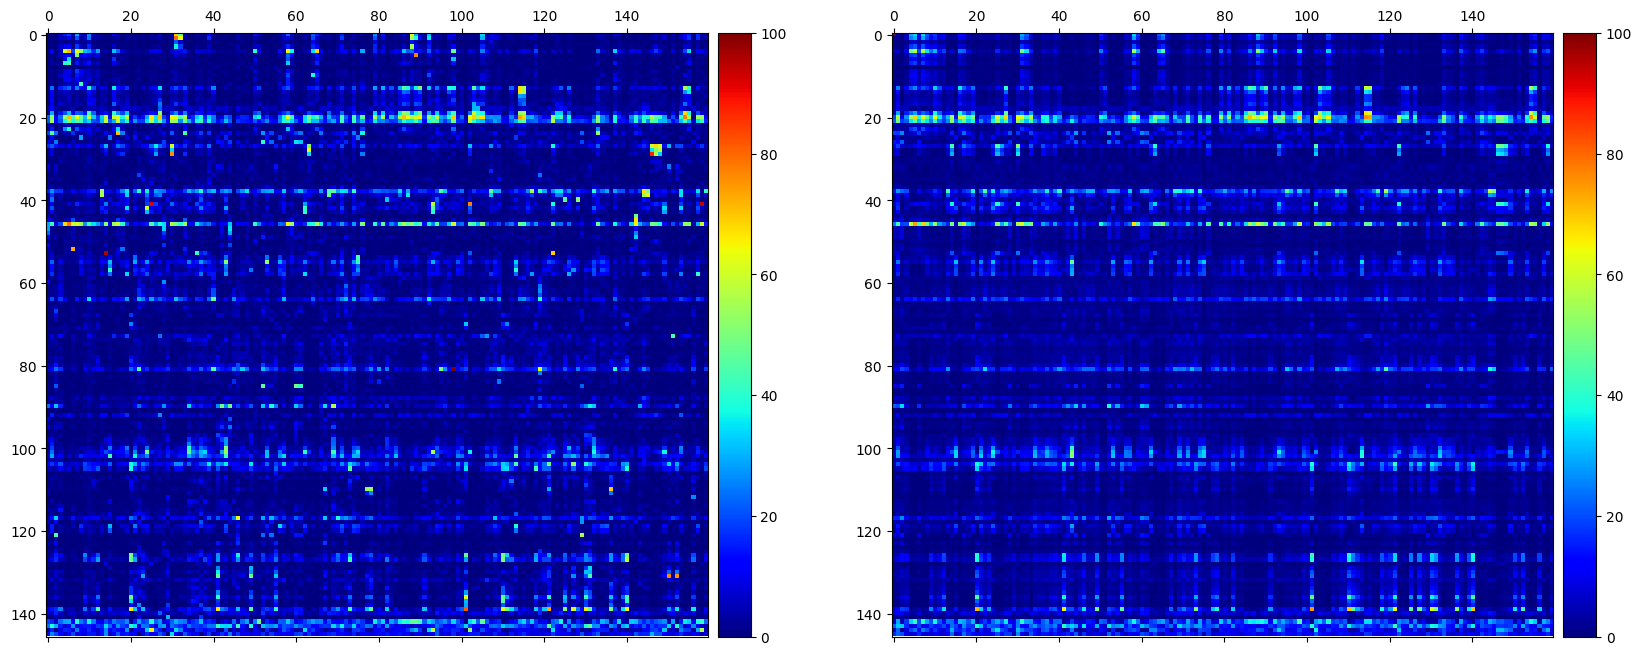

In [82]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
colorbar(ax1.matshow(data, cmap="jet"))
colorbar(ax2.matshow(WH, cmap="jet"))

plt.show()

In [76]:
np.linalg.norm(data - W_opt_drav@H_opt_drav)/data.shape[0]/data.shape[1]

0.02513952489400963